***Тестовое задание для вакансии «Младший исследователь данных (DS)***

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import chardet
from scipy.stats import ttest_ind
from scipy import stats
import streamlit as st
import matplotlib.pyplot as plt

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Откроем файл

In [2]:


with open('М.Тех_Данные_к_ТЗ_DS.csv', 'rb') as f:#Используем подбор кодировщика 
    result = chardet.detect(f.read())

data = pd.read_csv('М.Тех_Данные_к_ТЗ_DS.csv', encoding=result['encoding'], sep="\,", header=None)
data = data.apply(lambda x: x.str.replace(r"\"","", regex=True))#Убираем лишние кавычки 
data.columns = data.loc[0]
data.drop(index=0, inplace=True)
data

/tmp/ipykernel_222/967074628.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv('М.Тех_Данные_к_ТЗ_DS.csv', encoding=result['encoding'], sep="\,", header=None)


,Количество больничных дней,Возраст,Пол
1,5,39,Ж
2,4,54,М
3,4,26,М
4,5,42,М
5,4,29,М
...,...,...,...
233,5,30,М
234,4,36,Ж
235,2,60,Ж
236,2,44,Ж


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 1 to 237
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Количество больничных дней  237 non-null    object
 1   Возраст                     237 non-null    object
 2   Пол                         237 non-null    object
dtypes: object(3)
memory usage: 5.7+ KB


Колонки "Количество больничных дней" и "Возраст" имеют неверный тип данных. Приводем к числовому формату. 

In [4]:
import numpy as np
data["Количество больничных дней"] = data["Количество больничных дней"].astype(int)
data["Возраст"] = data["Возраст"].astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 1 to 237
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Количество больничных дней  237 non-null    int64 
 1   Возраст                     237 non-null    int64 
 2   Пол                         237 non-null    object
dtypes: int64(2), object(1)
memory usage: 5.7+ KB


Данные не имеют пропусков, столбцы приведены к нужному форимату, дополнительная предобработка не требуется. 


### Проверим гипотезы

***Проверим первую гипотезу:
Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин.***

In [5]:
# Посмотрим изначальное колличество мужчин и женщин в таблице, без учета фильтра 
men_women =(
   
    data.pivot_table(index=['Пол'], values='Количество больничных дней', aggfunc='count').reset_index()
    .sort_values(by=['Количество больничных дней'], ascending= False)
         
)
men_women

,Пол,Количество больничных дней
1,М,139
0,Ж,98


Мужчин в выборке больше чем женщин в 1.4 раза, посмотрим на соотношение после среза данных

In [6]:
men = data[(data['Количество больничных дней']> 2) & (data['Пол']== 'М')]# Делаем срез данных
women = data[(data['Количество больничных дней']> 2) & (data['Пол']== 'Ж')]


In [7]:

print('Колличество работников мужчин =',men['Количество больничных дней'].count(),'человек')

print('Колличество работников женщин =',women['Количество больничных дней'].count(),'человек')

Колличество работников мужчин = 84 человек
Колличество работников женщин = 67 человек


В срезе данных мужчин в 1.25 раза больше чем женщин

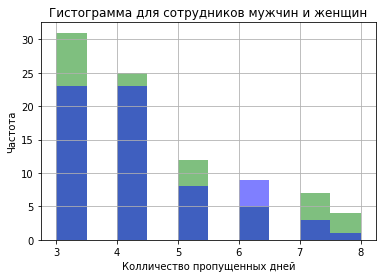

In [8]:
plt.title('Гистограмма для сотрудников мужчин и женщин')# Нарисуем гистограмму
plt.xlabel('Колличество пропущенных дней')
plt.ylabel('Частота')
men['Количество больничных дней'].hist( alpha=0.5, color='green')
women['Количество больничных дней'].hist( alpha=0.5, color='blue')
plt.show()

Зеленым цветом обозначены сотрудники мужчины 
Синим цветом сотрудники женщины. 

На графике не видно явных скачков показывающих что один из полов пропускает значительно больше рабочих дней чем другой. Финальное заключение сделаем на основе статистического теста 

*Гипотеза № 1
Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин.
Нулевая гипотеза (H0): Среднее количество пропущенных рабочих дней мужчинами и женщинами одинаково.
Альтернативная гипотеза (H1): Среднее количество пропущенных рабочих дней мужчинами больше, чем у женщин.*

In [9]:
# Проверка гипотезы о равенстве средних двух выборок
t_stat, p_value = stats.ttest_ind(men['Количество больничных дней'], women['Количество больничных дней'])

# Определение уровня значимости
alpha = 0.05

# Сравнение уровня значимости с p-value
if p_value < alpha:
    print('Различие между средним количеством пропущенных рабочих дней по болезни у мужчин и женщин является значимым.')
else:
    print('Различие между средним количеством пропущенных рабочих дней по болезни у мужчин и женщин не является значимым.')
print('p-значение:', p_value)        

Различие между средним количеством пропущенных рабочих дней по болезни у мужчин и женщин не является значимым.
p-значение: 0.67806332103283


**Из статистичесого t-теста выидим что нельзя отвергнуть нулевую гипотезу,это значит что нельзя утверждать что среднее колличество пропущенных рабочих дней у мужчин и женщин различно. Иными словами среднее количество пропущенных рабочих дней мужчинами и женщинами одинаково.**

Проведем иследование второй гипотезы сформулированную следующим образом:
Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.

In [10]:
older_employees = data[(data['Количество больничных дней']> 2) & (data['Возраст']> 35)]# Делаем сруз данных
younger_employees = data[(data['Количество больничных дней']> 2) & (data['Возраст']< 35)]

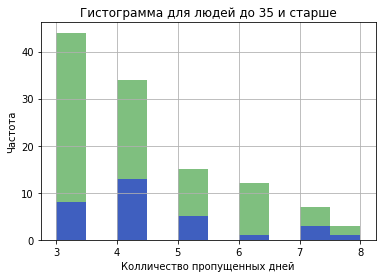

In [11]:
plt.title('Гистограмма для людей до 35 и старше')# Нарисуем гистограмму
plt.xlabel('Колличество пропущенных дней')
plt.ylabel('Частота')
older_employees['Количество больничных дней'].hist( alpha=0.5, color='green')
younger_employees['Количество больничных дней'].hist( alpha=0.5, color='blue')
plt.show()

Зеленым цветом обозначены сотрудники старше 35 лет
Синим цветом сотрудники до 35 лет

In [12]:
print('Колличество работников старше 35 лет =',older_employees['Количество больничных дней'].count(),'человек')

print('Колличество работников младше 35 лет =',younger_employees['Количество больничных дней'].count(),'человек')

Колличество работников старше 35 лет = 115 человек
Колличество работников младше 35 лет = 31 человек


Как выдно из гистограммы колличество пропущенных дней у людей в возрасте больше 35 лет значительно выше, чем у людей до 35 лет. Но однозначно делать выводы на основе графика нельзя, так как соотношение людей людей в выборке не пропорционально 115 - работников больше 35 лет, против 31 - сотрудника моложе 35 лет. Полную картину покажет статистический тест

*Гипотеза № 2
Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.
Нулевая гипотеза (H0): Среднее количество пропущенных рабочих дней сотрудниками старше 35 лет и их более молодыми коллегами одинаково.
Альтернативная гипотеза (H1): Среднее количество пропущенных рабочих дней сотрудниками старше 35 лет больше, чем у их более молодых коллег.*

In [13]:
# Проведение t-теста для сравнения средних значений
t_stat, p_value = stats.ttest_ind(older_employees['Количество больничных дней'], younger_employees['Количество больничных дней'])
# Определение уровня значимости
alpha = 0.05
# Вывод результатов теста
if p_value < alpha:
    print("Работники старше 35 лет пропускают в течение года более 2 рабочих дней по болезни значимо чаще своих более молодых коллег.")
else:
    print("Нет значимого различия в пропусках по болезни между работниками старше 35 лет и их более молодыми коллегами.")
print('p-значение:', p_value)    

Нет значимого различия в пропусках по болезни между работниками старше 35 лет и их более молодыми коллегами.
p-значение: 0.6027265658515909


**Как видно из t-теста невозможно отвергнуть гипотезу о равенстве средних пропущенных дней у сотрудников до 35 лет и старше.**


***По итогу иследования были провернны следующие гипотезы:***
***1) Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин.***
***2) Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.***
***В результате иследования были отвергнуты обе данные гипотезы, так по результату статистических тестов среднее колличество пропущенных дней между мужчинами и женщинами равны, так же каки среднее значение у людей до 35 лет и старше.***